### Installing dependencies and whatever is needed

In [ ]:
%pip install tensorflow opencv-python matplotlib

In [1]:
%pip list | grep tensorflow

tensorflow              2.16.2
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf 
import os

In [5]:
os.listdir('/Users/user/Documents/GitHub/CNN-classifier/App')

['main.ipynb']

### Removing dodgy images

In [ ]:
import cv2
import imghdr

In [16]:
data_dir = '../data/'

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
image_exts[0]

'jpeg'

In [18]:
os.listdir(data_dir)

['happy', '.DS_Store', 'sad']

In [19]:
for image_class in os.listdir(data_dir):
    print(image_class)

happy
.DS_Store
sad


In [24]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue
    
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))
            

In [27]:
img = cv2.imread(os.path.join('../', 'data', 'happy','_happy_jumping_on_beach-40815.jpg'))
img.shape

(213, 320, 3)

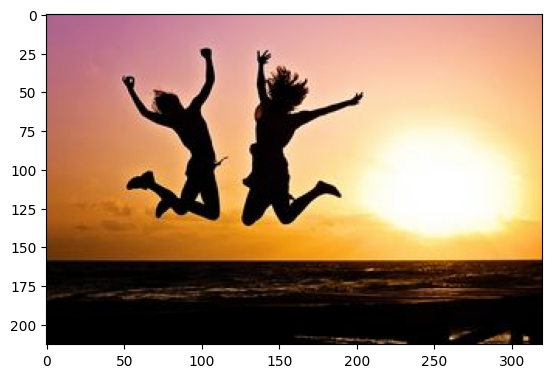

In [44]:
from matplotlib import pyplot as plt 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Load data

In [ ]:
tf.data.Dataset

In [30]:
import numpy as np 

In [31]:
tf.keras.utils.image_dataset_from_directory

<function keras.src.utils.image_dataset_utils.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, pad_to_aspect_ratio=False, data_format=None, verbose=True)>

In [68]:
data = tf.keras.utils.image_dataset_from_directory('../data')

Found 165 files belonging to 2 classes.


In [34]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [35]:
data_iterator = data.as_numpy_iterator()

In [36]:
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x12fae6540>)

In [37]:
batch = data_iterator.next()

In [42]:
print(len(batch))

2


In [41]:
batch[0].shape # Images represented as numpy arrays

(32, 256, 256, 3)

In [43]:
batch[1] # The labels

array([0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1], dtype=int32)

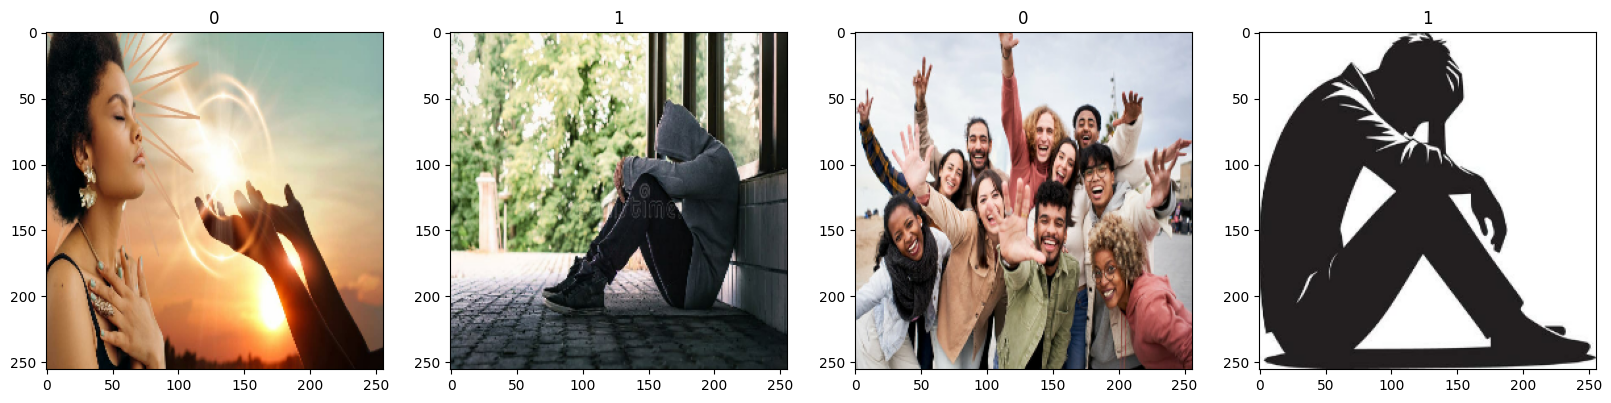

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [53]:
type(idx)

int

### Preprocess data

- Scale data

In [54]:
scaled = batch[0] / 255

In [55]:
scaled.max()

1.0

In [69]:
data = data.map(lambda x,y: (x/255, y))

In [70]:
scaled_iterator = data.as_numpy_iterator()

In [71]:
scaled_iterator.next()[0].max()

1.0

- Split Data

In [72]:
len(data)

6

In [75]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) + 1

In [76]:
print(train_size)
print(val_size)
print(test_size)

4
1
1


In [79]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [80]:
print(len(train))
print(len(val))
print(len(test))

4
1
1


### Deep Model

- Build Deep Learning Model

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [86]:
model = Sequential()

In [87]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [88]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

- Train

In [90]:
logdir = '../logs'
if os.path.isdir(logdir):
    print('yes')

yes


In [91]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [92]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6500 - loss: 1.0706 - val_accuracy: 0.4062 - val_loss: 1.7141
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4688 - loss: 1.2377 - val_accuracy: 0.5938 - val_loss: 0.5948
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5906 - loss: 0.6200 - val_accuracy: 0.7812 - val_loss: 0.6124
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8083 - loss: 0.5860 - val_accuracy: 0.7812 - val_loss: 0.5040
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7802 - loss: 0.5113 - val_accuracy: 0.8125 - val_loss: 0.3862
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7625 - loss: 0.4565 - val_accuracy: 0.9375 - val_loss: 0.3624
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 938ms/step - accuracy: 0.8479 - loss: 0.3849 - val_accuracy: 0.9062 - val_loss: 0.2764
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 986ms/step - accuracy: 0.8573 - loss: 0.2880 - val_accuracy: 0.8750 - val_loss: 0.3366
Epoch 9/20

In [93]:
hist.history

{'accuracy': [0.6015625,
  0.5234375,
  0.6015625,
  0.7890625,
  0.7890625,
  0.765625,
  0.84375,
  0.859375,
  0.828125,
  0.8984375,
  0.9296875,
  0.9140625,
  0.9609375,
  0.9453125,
  0.96875,
  0.984375,
  0.984375,
  0.984375,
  1.0,
  1.0],
 'loss': [1.2215595245361328,
  1.003316044807434,
  0.6264520287513733,
  0.5772289633750916,
  0.5036669969558716,
  0.4544704258441925,
  0.38539716601371765,
  0.29102838039398193,
  0.313323438167572,
  0.2512625455856323,
  0.24481914937496185,
  0.19940340518951416,
  0.1555713713169098,
  0.12354087829589844,
  0.09890423715114594,
  0.09003262221813202,
  0.07147497683763504,
  0.043245021253824234,
  0.0368695892393589,
  0.02233157679438591],
 'val_accuracy': [0.40625,
  0.59375,
  0.78125,
  0.78125,
  0.8125,
  0.9375,
  0.90625,
  0.875,
  0.96875,
  0.84375,
  0.9375,
  0.9375,
  0.96875,
  0.96875,
  0.96875,
  0.96875,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [1.7141112089157104,
  0.5947926044464111,
  0.6124203205108643

- Plot Performance

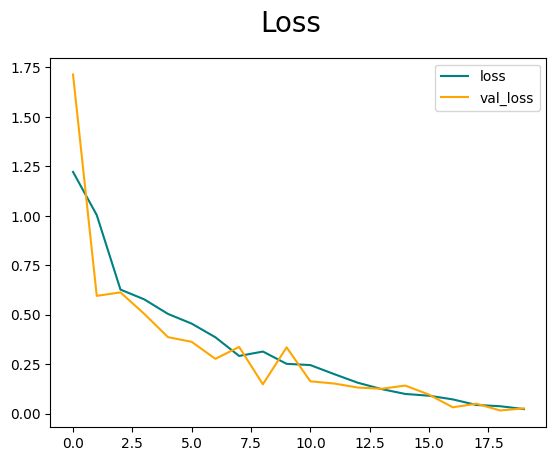

In [96]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

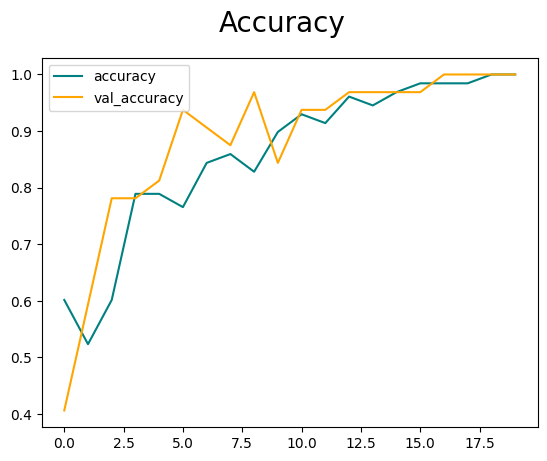

In [98]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluating Performance

- Evaluate

In [99]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [100]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [101]:
type(pre)

keras.src.metrics.confusion_metrics.Precision

In [103]:
test_size

1

In [104]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


2025-03-09 17:43:33.398686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [107]:
print(f"Precision: {pre.result().numpy()}")
print(f"Recall: {re.result().numpy()}")
print(f"BinaryAccuracy: {acc.result().numpy()}")

Precision: 1.0
Recall: 1.0
BinaryAccuracy: 1.0


- Test

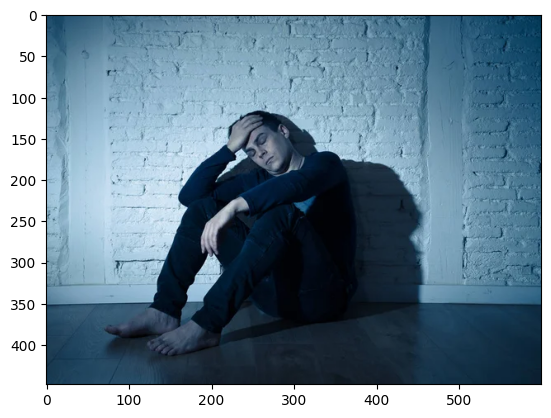

In [153]:
img = cv2.imread('../test/sadtest2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [154]:
resize = tf.image.resize(img, (256,256))

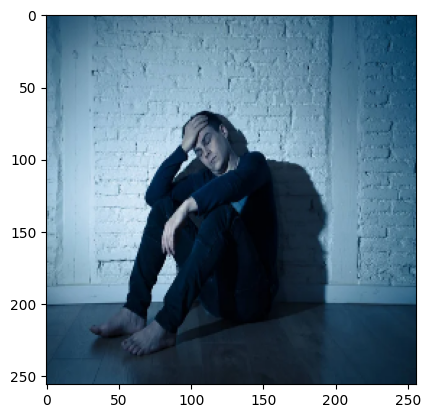

In [155]:
plt.imshow(cv2.cvtColor(resize.numpy().astype('uint8'), cv2.COLOR_BGR2RGB))
plt.show()

In [156]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [157]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [158]:
if yhat > 0.5:
    print('e suparat ma')
else:
    print('e fericit regele')

e suparat ma
